In [1]:
import os
from pybedtools import BedTool
import pandas as pd
import seaborn as sns
indir = '/home/hsher/scratch/circ_nextera_iter3/output/'
circ_quant_output = [os.path.join(indir,f) for f in os.listdir(indir) if f.endswith('.gtf')]
indir = '/home/hsher/scratch/circ_truseq_iter3/output/'
circ_quant_output += [os.path.join(indir,f) for f in os.listdir(indir) if f.endswith('.gtf')]

In [3]:
def read_ciri_gtf(fname):
    bed = BedTool(fname)
    df = bed.to_dataframe()
    # filter for non-entries
    stat = df.loc[df['seqname'].str.contains('##'), 'seqname'].str.split(': ', expand = True)
    df = df.loc[~df['seqname'].str.contains('##')].reset_index()
    
    # get attributes
    attrs = pd.DataFrame([i.attrs for i in bed])
    
    return pd.concat([df, attrs], axis = 1), stat

In [4]:
circ_type_count = []
names = []
junc_ratio_tbl = []
bsj_ratio_tbl = []
fsj_ratio_tbl = []
stats = []
for fname in circ_quant_output:
    name = os.path.basename(fname).replace('.gtf', '')
    names.append(name)
    
    circ_df, stat = read_ciri_gtf(fname)
    
    circ_type_count.append(circ_df['circ_type'].value_counts())
    
    junc_ratio_tbl.append(circ_df.set_index('circ_id')['junc_ratio'].astype(float))
    bsj_ratio_tbl.append(circ_df.set_index('circ_id')['bsj'].astype(float))
    fsj_ratio_tbl.append(circ_df.set_index('circ_id')['fsj'].astype(float))
    stats.append(stat.set_index(0))

In [5]:
stats_df = pd.concat(stats, axis = 1).T

In [6]:
stats_df.columns

Index(['##Sample', '##Total_Reads', '##Mapped_Reads', '##Circular_Reads',
       '##version'],
      dtype='object', name=0)

In [7]:
for col in ['##Total_Reads', '##Mapped_Reads', '##Circular_Reads']:
    stats_df[col] = stats_df[col].astype(int)

In [8]:
stats_df['frac_circular'] = stats_df['##Circular_Reads']/stats_df['##Mapped_Reads']
stats_df['frac_mapped'] = stats_df['##Mapped_Reads']/stats_df['##Total_Reads']

In [9]:
stats_df.sort_values('frac_circular')
stats_df.set_index('##Sample', inplace = True)

In [26]:
stats_df['library_prep']=pd.Series(stats_df.index).apply(lambda x: 'rar11' if 'rar11' in x else 'rz').tolist()

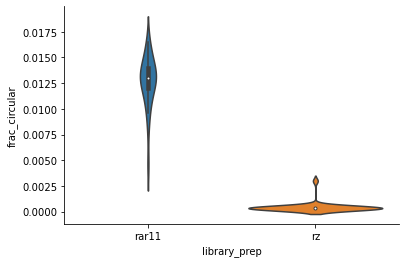

In [34]:
sns.violinplot(data = stats_df, x= 'library_prep', y = 'frac_circular', figsize = (3,3))
sns.despine()

In [49]:
stats_df.loc['RCA_rar11']

0
##Total_Reads        161457144
##Mapped_Reads        39160922
##Circular_Reads        322356
##version                1.1.2
frac_circular       0.00823157
frac_mapped           0.242547
library_prep             rar11
Name: RCA_rar11, dtype: object

# make gtf manifest

In [40]:
de_menifest = pd.DataFrame([circ_quant_output], index = ['gtf']).T

In [55]:
from pathlib import Path
de_menifest['libname']=de_menifest['gtf'].apply(lambda path: Path(path).name.split('_')[0])
de_menifest['protocol']=de_menifest['gtf'].apply(lambda path: Path(path).name.split('_')[1].replace('.gtf', ''))

In [56]:
de_menifest['libname'].value_counts()

siDDX52      2
siDDX19A     2
ZC3HAV1      2
siZC3HAV1    2
THOC1        2
HEK          2
siTOB2       2
DDX19A       2
RBM17        2
RPS10        2
DCP1A        2
G3BP2        2
DDX52        2
siG3BP2      2
LARP4        2
siRBM15      2
EIF3C        2
siLARP4B     2
siLARP4      2
siRBM17      2
U2AF2        2
siANXA2      2
ANXA2        2
siDCP1A      2
siU2AF2      2
LARP4B       2
siTHOC1      2
siNT         2
RCA          1
Name: libname, dtype: int64

In [57]:
de_menifest['protocol'].value_counts()

rz       28
rar11    28
arr       1
Name: protocol, dtype: int64

In [58]:
de_menifest.loc[de_menifest['protocol']=='arr']

,gtf,libname,protocol
31,/home/hsher/scratch/circ_truseq_iter3/output/H...,HEK,arr


In [59]:
de_menifest.loc[de_menifest['libname']=='HEK']

,gtf,libname,protocol
31,/home/hsher/scratch/circ_truseq_iter3/output/H...,HEK,arr
56,/home/hsher/scratch/circ_truseq_iter3/output/H...,HEK,rz


In [61]:
de_menifest.loc[de_menifest['libname']=='siTHOC1']

,gtf,libname,protocol
8,/home/hsher/scratch/circ_nextera_iter3/output/...,siTHOC1,rar11
35,/home/hsher/scratch/circ_truseq_iter3/output/s...,siTHOC1,rz


In [81]:
de = pd.pivot_table(de_menifest, index = 'libname', columns = ['protocol'], values = 'gtf', aggfunc = lambda x:x)
de = de[['rar11', 'rz']].dropna()
de=de.rename({'rar11':'RNase+', 'rz':'RNase-'}, axis = 1)
de['sample_label']=de['RNase+'].apply(lambda path: Path(path).name.replace('.gtf',''))
# add EV
de.loc['EV']=['/home/hsher/scratch/circ_nextera_iter2/output/EV_rar11.gtf','/home/hsher/scratch/circ_truseq_iter2/output/EV_rz.gtf', 'EV_rar11']

In [83]:
de.to_csv('deseq_tether_iter1.csv')

In [85]:
de

protocol,RNase+,RNase-,sample_label
libname,,,
ANXA2,/home/hsher/scratch/circ_nextera_iter3/output/...,/home/hsher/scratch/circ_truseq_iter3/output/A...,ANXA2_rar11
DCP1A,/home/hsher/scratch/circ_nextera_iter3/output/...,/home/hsher/scratch/circ_truseq_iter3/output/D...,DCP1A_rar11
DDX19A,/home/hsher/scratch/circ_nextera_iter3/output/...,/home/hsher/scratch/circ_truseq_iter3/output/D...,DDX19A_rar11
DDX52,/home/hsher/scratch/circ_nextera_iter3/output/...,/home/hsher/scratch/circ_truseq_iter3/output/D...,DDX52_rar11
EIF3C,/home/hsher/scratch/circ_nextera_iter3/output/...,/home/hsher/scratch/circ_truseq_iter3/output/E...,EIF3C_rar11
G3BP2,/home/hsher/scratch/circ_nextera_iter3/output/...,/home/hsher/scratch/circ_truseq_iter3/output/G...,G3BP2_rar11
LARP4,/home/hsher/scratch/circ_nextera_iter3/output/...,/home/hsher/scratch/circ_truseq_iter3/output/L...,LARP4_rar11
LARP4B,/home/hsher/scratch/circ_nextera_iter3/output/...,/home/hsher/scratch/circ_truseq_iter3/output/L...,LARP4B_rar11
RBM17,/home/hsher/scratch/circ_nextera_iter3/output/...,/home/hsher/scratch/circ_truseq_iter3/output/R...,RBM17_rar11


In [86]:
si_trials = [s for s in de['sample_label'] if s.startswith('si') and s != 'siNT_rar11']

In [87]:
ov_trials = [s for s in de['sample_label'] if not s.startswith('si') and s != 'EV_rar11']

In [88]:
si_trials

['siANXA2_rar11',
 'siDCP1A_rar11',
 'siDDX19A_rar11',
 'siDDX52_rar11',
 'siG3BP2_rar11',
 'siLARP4_rar11',
 'siLARP4B_rar11',
 'siRBM15_rar11',
 'siRBM17_rar11',
 'siTHOC1_rar11',
 'siTOB2_rar11',
 'siU2AF2_rar11',
 'siZC3HAV1_rar11']

In [89]:
ov_trials

['ANXA2_rar11',
 'DCP1A_rar11',
 'DDX19A_rar11',
 'DDX52_rar11',
 'EIF3C_rar11',
 'G3BP2_rar11',
 'LARP4_rar11',
 'LARP4B_rar11',
 'RBM17_rar11',
 'RPS10_rar11',
 'THOC1_rar11',
 'U2AF2_rar11',
 'ZC3HAV1_rar11']